# Data management & summary statistics

First thing to do is load the required packages: dplyr for data management/manipulation and ggplot2 for visualizations. The dataset itself is contained in the "nycflights13" package. 

In [1]:
options(digits = 2) # use two decimal places for all floating-point values

library(dplyr) # data management
library(ggplot2) # visualizations
library(nycflights13) # dataset


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




The nycflights13 package also includes information about the aircraft which made each flight. This information may be useful, so let's combine it with the flights data. We can also replace the two-character carrier codes with the names of the airlines they represent. Then, we'll print some basic summary statistics. 

In [2]:
# add airplane and carrier data
flights_full = flights %>% 
  left_join(airlines, by = "carrier") %>% 
  left_join(planes %>% 
              select(tailnum, type, manufacturer, model, engine), 
            by = "tailnum") %>% 
  select(-carrier)

# summary
summary(flights_full)

      year          month           day          dep_time    sched_dep_time
 Min.   :2013   Min.   : 1.0   Min.   : 1.0   Min.   :   1   Min.   : 106  
 1st Qu.:2013   1st Qu.: 4.0   1st Qu.: 8.0   1st Qu.: 907   1st Qu.: 906  
 Median :2013   Median : 7.0   Median :16.0   Median :1401   Median :1359  
 Mean   :2013   Mean   : 6.5   Mean   :15.7   Mean   :1349   Mean   :1344  
 3rd Qu.:2013   3rd Qu.:10.0   3rd Qu.:23.0   3rd Qu.:1744   3rd Qu.:1729  
 Max.   :2013   Max.   :12.0   Max.   :31.0   Max.   :2400   Max.   :2359  
                                              NA's   :8255                 
   dep_delay       arr_time    sched_arr_time   arr_delay        flight    
 Min.   : -43   Min.   :   1   Min.   :   1   Min.   : -86   Min.   :   1  
 1st Qu.:  -5   1st Qu.:1104   1st Qu.:1124   1st Qu.: -17   1st Qu.: 553  
 Median :  -2   Median :1535   Median :1556   Median :  -5   Median :1496  
 Mean   :  13   Mean   :1502   Mean   :1536   Mean   :   7   Mean   :1972  
 3rd Qu.:  1

The main goal of this project is to predict arrival delay. However, we can see above that there are 9430 entries for which the arrival time was not recorded. We can't use these entries for supervised learning, so let's remove them. 

In [3]:
# remove all flights with no arrival delay
flights_full = flights_full %>% 
  filter(!is.na(flights_full$arr_delay))

The summary() function doesn't count the number of missing values in columns with the "character" data type. We will have to do that manually. Fortunately, because they are categorical variables, we can simply replace them with "unknown". 

In [4]:
# count missing values per column
data.frame(sapply(flights_full, function(x) sum(is.na(x)))) %>% 
  rename(missing_values = 1) %>% 
  filter(missing_values > 0) %>% 
  arrange(desc(missing_values)) %>% 
  print()

# replace missing values in dataframe
flights_full[is.na(flights_full)] = "Unknown"

             missing_values
type                  48329
manufacturer          48329
model                 48329
engine                48329


In this dataset, times are represented in (hour * 100) + minute. Let's change these times into the number of minutes after midnight. 

Month and day are recorded as two separate variables. However, we can easily combine these into a single numeric value (specifically, the day of the year). 

In [5]:
# convert hrs/mins into minutes
dep_mins = (flights_full$dep_time %% 100) + (flights_full$dep_time - (flights_full$dep_time %% 100)) * 0.6
sched_dep_mins = (flights_full$sched_dep_time %% 100) + (flights_full$sched_dep_time - (flights_full$sched_dep_time %% 100)) * 0.6
arr_mins = (flights_full$arr_time %% 100) + (flights_full$arr_time - (flights_full$arr_time %% 100)) * 0.6
sched_arr_mins = (flights_full$sched_arr_time %% 100) + (flights_full$sched_arr_time - (flights_full$sched_arr_time %% 100)) * 0.6

# convert month/day into day of year
days_per_month = c(0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365)
day_of_year = days_per_month[flights_full$month] + flights_full$day

# add new columns to dataframe
flights_full = flights_full %>% 
  mutate(dep_mins, 
         sched_dep_mins, 
         arr_mins, 
         sched_arr_mins, 
         day_of_year)

# Exploratory Data Analysis

We have done most of the important data management. Now, let's do some basic exploratory data analysis. 

Because of the size of this dataset (327,346 rows), I have decided to calculate averages for the visualizations instead of using every single entry. I am doing this because the visualizations will take much less time to generate, and they will be much more readable (less noise in exchange for a small loss of accuracy). 

I'm guessing that the time of year should have some kind of impact on the average arrival delay. This visualization plots the average arrival delay on the vertical axis, and the day of the year on the horizontal axis. These values are quite noisy, so the blue line attempts to remove this noise and reveal the underlying trend. 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


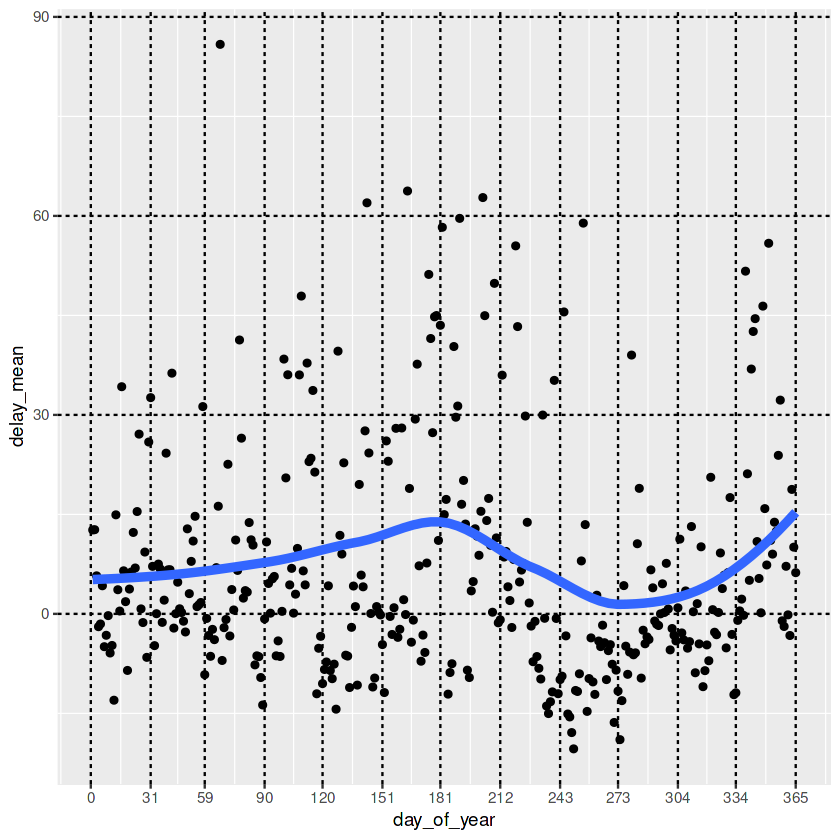

In [6]:
# mean delay by day of year
by_day = flights_full %>% 
  group_by(day_of_year) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay))

ggplot(by_day, mapping = aes(x = day_of_year, y = delay_mean)) + 
  geom_point() + 
  geom_smooth(se = FALSE, linewidth = 2) + 
  scale_x_continuous(breaks = days_per_month) + 
  theme(panel.grid.major = element_line(color = "black", 
                                        linewidth = 0.5, 
                                        linetype = 2))

The average arrival delay increased steadily until June/July, then quickly lowered until September/October before rising until the end of the year. 

Now, a similar visualization for the scheduled departure time: 

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


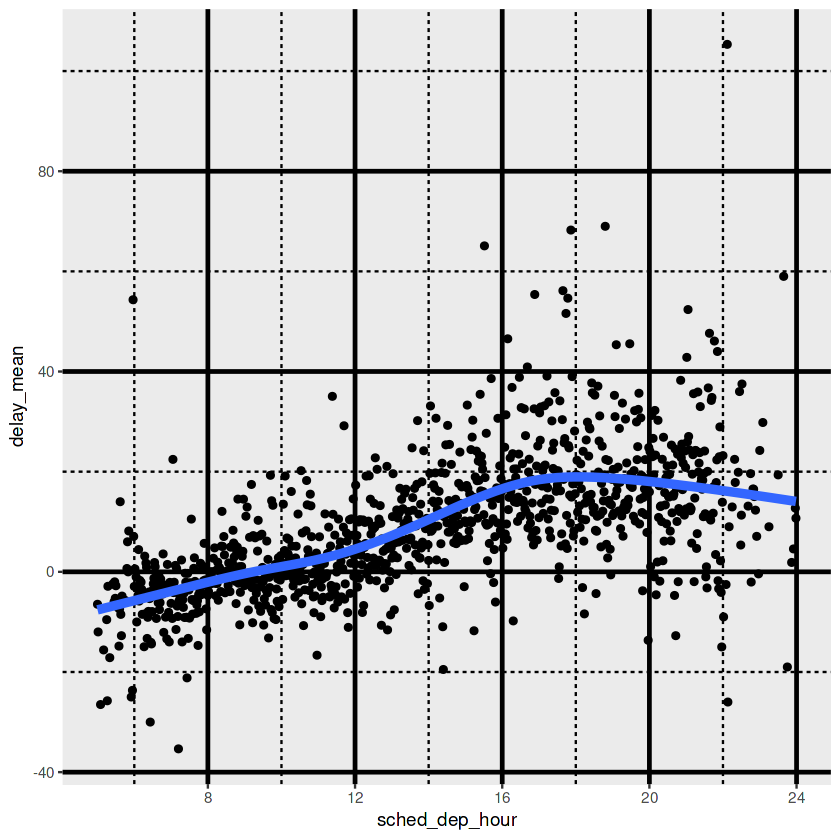

In [7]:
# mean delay by scheduled departure time
flights_full %>% 
  group_by(sched_dep_mins) %>% 
  summarize(delay_mean = mean(arr_delay), 
            total = sum(n())) %>% 
  arrange(sched_dep_mins) %>% 
  mutate(sched_dep_hour = sched_dep_mins / 60) %>% 
  select(-sched_dep_mins) %>% 
  ggplot(mapping = aes(x = sched_dep_hour, y = delay_mean)) + 
  geom_point() + 
  geom_smooth(se = FALSE, linewidth = 2) + 
  scale_x_continuous(breaks = seq(0, 24, by = 4)) + 
  theme(panel.grid.major = element_line(color = "black", 
                                        linewidth = 1, 
                                        linetype = 1)) + 
  theme(panel.grid.minor = element_line(color = "black", 
                                        linewidth = 0.5, 
                                        linetype = 2))

Arrival delay climbs steadily until reaching a maximum of 20 minutes between 5PM and 7PM, then gradually decreases. 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


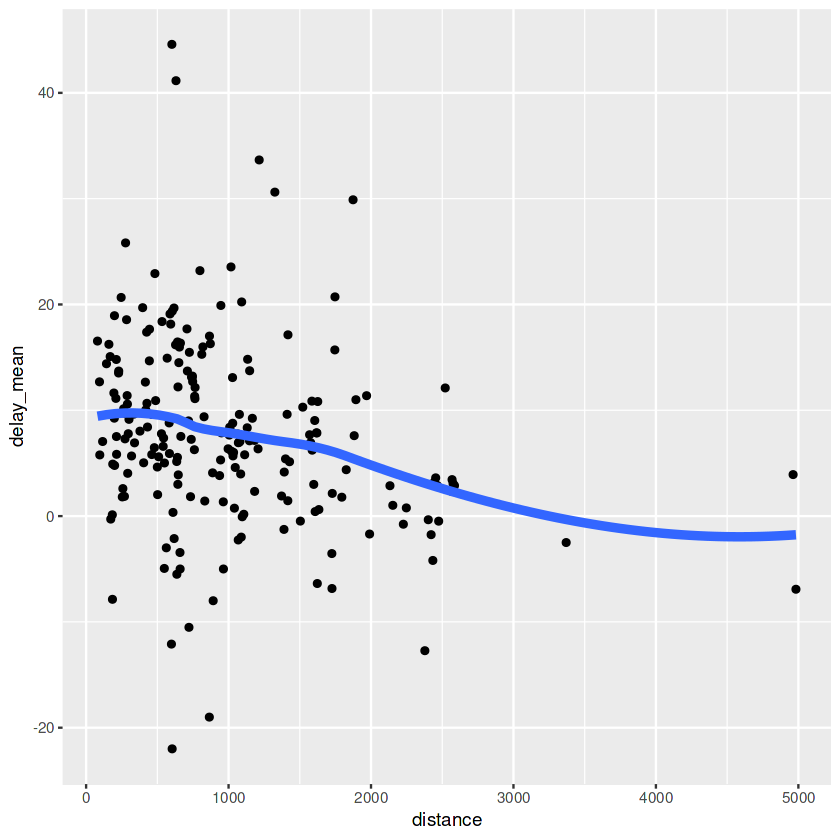

In [8]:
# by distance
flights_full %>% 
  group_by(distance) %>% 
  summarize(delay_mean = mean(arr_delay), 
            total = sum(n())) %>% 
  ggplot(by_distance, mapping = aes(x = distance, y = delay_mean)) + 
  geom_point() + 
  geom_smooth(se = FALSE, linewidth = 2)

There is a weak negative correlation between distance (from origin airport to destination airport) and arrival delay. 

In [9]:
# table: mean delay by airline
by_airline = flights_full %>% 
  group_by(name) %>% 
  summarize(delay_mean = mean(arr_delay), 
            total = sum(n())) %>% 
  arrange(delay_mean)
by_airline

name,delay_mean,total
<chr>,<dbl>,<int>
Alaska Airlines Inc.,-9.93,709
Hawaiian Airlines Inc.,-6.92,342
American Airlines Inc.,0.36,31947
Delta Air Lines Inc.,1.64,47658
Virgin America,1.76,5116
US Airways Inc.,2.13,19831
United Air Lines Inc.,3.56,57782
Endeavor Air Inc.,7.38,17294
JetBlue Airways,9.46,54049


There is a clear difference in arrival delay between airlines. Hawaiian and Alaskan flights arrived early by an average of 7 and 10 minutes, respectively. AirTran and Frontier both had average arrival delays greater than 20 minutes. 

In [10]:
# table: mean delay by origin
by_origin = flights_full %>% 
  group_by(origin) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay))
by_origin

origin,total,delay_mean
<chr>,<int>,<dbl>
EWR,117127,9.1
JFK,109079,5.6
LGA,101140,5.8


On average, flights leaving from Newark were 9 minutes late, while flights from JFK and LaGuardia were 5.5 to 6 minutes late. 

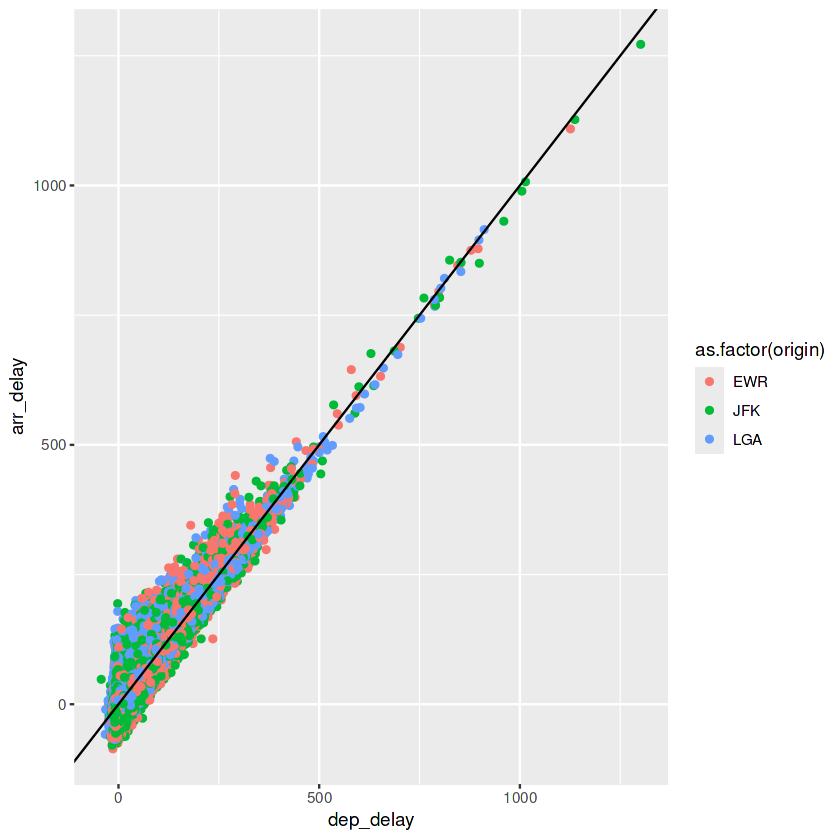

In [11]:
# scatter: departure delay vs arrival delay
flights_full %>% 
  ggplot(mapping = aes(x = dep_delay, y = arr_delay, color = as.factor(origin)), position = "jitter") + 
  geom_point() + 
  geom_abline(slope = 1)

Unsurprisingly, there is a very strong positive correlation between departure delay and arrival delay. The black line is not a regression line (it has the equation y = x). 